# Novozymes Enzyme Stability Prediction

This challenge was proposed in the scope of an assigment regarding machine learning-based data analysis of the curricular unit "Intelligent Systems for Bioinformatics" integrated in the Bioinformatics Master Degree at University of Minho, 2022-2023. The code was developed by Group 6 composed of: 

*   Ana Camila Ribeiro de Babo, PG45964;
*   Tomás Carreiró Carvalho Silva e Sá, PG45477;
*   José Diogo Cruz de Moura, PG45965.

The challenge was part of a Kaggle competition with the goal to predict the thermostability of enzyme variants through the use of natural and engineered sequences with single or multiple mutations whose thermostability was experimentally measured.

## Overview

Enzymes are proteins that catalyze chemical reactions in living organisms. They are important for a variety of biological processes, including metabolism, digestion, and gene expression. Enzymes are also used in a wide range of industrial applications, as they can accelerate chemical reactions and improve the efficiency of processes such as food processing, textile manufacturing, and pharmaceutical production.

One important characteristic of enzymes is their thermostability, which refers to their ability to maintain their activity over a range of temperatures. Predicting enzyme thermostability is important in order to optimize the use of enzymes in industrial processes and to ensure their sustainability. If enzymes are not stable at the temperature at which they are used, they may denature and lose their activity, which can lead to decreased efficiency and increased waste. By predicting enzyme thermostability, it is possible to select enzymes that are suitable for specific industrial processes and to optimize the conditions under which they are used.

Optimizing the thermostability of enzymes can also have environmental benefits, as it can reduce the energy required to operate industrial processes and minimize the production of waste. By using enzymes that are stable at lower temperatures, it may be possible to reduce the energy needed to maintain optimal conditions for enzyme activity. Similarly, using enzymes that are stable over a wider range of temperatures may allow for more flexibility in the design of industrial processes and may lead to more efficient and sustainable operations.

In conclusion, predicting enzyme thermostability is important for optimizing the use of enzymes in industrial processes and for ensuring their sustainability. By selecting enzymes that are stable at the temperatures at which they are used, it is possible to improve the efficiency of industrial processes and to minimize waste and energy consumption.

### Dataset features

**seq_id**: Unique identifier of each protein variants.

**protein_sequence**: Amino acid sequence of each protein variant. The stability (as measured by tm) of protein is determined by its protein sequence. (Please note that most of the sequences in the test data have the same length of 221 amino acids, but some of them have 220 because of amino acid deletion.)

**pH**: The scale used to specify the acidity of an aqueous solution under which the stability of protein was measured. Stability of the same protein can change at different pH levels.

**data_source**: Source where the data was published.

**tm**: Target column. Since only the spearman correlation will be used for the evaluation, the correct prediction of the relative order is more important than the absolute tm values. (Higher tm means the protein variant is more stable.)


## Data Exploration and Pre-processing


The first step of this work involves importing the datasets and the necessary libraries to perform an exploratory data analysis in order to retrieve insights from the data and possibly find patterns and/or anomalies. We will also do apply some pre-processing techniques to transform the data in the most efficient way for the ML pipeline.

In [ ]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
#from propythia.sequence import ReadSequence
#from propythia.protein_descriptores import ProteinDescritors
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score

In [ ]:
# import the training and testing set
original_train_df = pd.read_csv("../data_files/train.csv")
test_df = pd.read_csv("../data_files/test.csv")

In [ ]:
# import the updated training set
# the initially given training dataset had inaccuracies in some entries and, as such, the competition staff uploaded a file with corrections
updated_train_df = pd.read_csv("../data_files/train_updates_20220929.csv")

### Training dataset

In [ ]:
# checking the shape of the training dataset
original_train_df = original_train_df.set_index("seq_id")
print(f"The shape of the training dataset is {original_train_df.shape}")

The shape of the training dataset is (31390, 4)


In [ ]:
# checking the structure of the dataset
original_train_df.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [ ]:
# gather information about the training set
original_train_df.info()
original_train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31390 entries, 0 to 31389
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  31390 non-null  object 
 1   pH                31104 non-null  float64
 2   data_source       28043 non-null  object 
 3   tm                31390 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.2+ MB


,pH,tm
count,31104.000000,31390.000000
mean,6.892339,49.147337
std,1.612225,14.010089
min,1.990000,-1.000000
25%,7.000000,42.100000
50%,7.000000,48.000000
75%,7.000000,53.800000
max,64.900000,130.000000


In [ ]:
# information about the total number of null values of each feature
original_train_df.isnull().sum()

protein_sequence       0
pH                   286
data_source         3347
tm                     0
dtype: int64

In [ ]:
# incorrect data in the training dataset (pH and tm transposed rows)
ph = original_train_df['pH']
count = ph[ph > 11]
count

seq_id
973      48.4
986      48.4
988      49.0
989      55.6
1003     48.4
1012     48.4
1014     55.6
1018     49.0
1037     49.0
1042     48.4
1079     55.6
1081     49.0
1088     48.4
1093     48.4
1096     48.4
1098     48.4
1100     55.6
1108     49.0
1111     55.6
1120     48.4
1122     48.4
1125     48.4
13447    64.9
13449    64.9
14640    39.0
22116    53.4
22123    53.4
22131    53.4
22145    53.4
Name: pH, dtype: float64

### Assemble the correct training dataset

In [ ]:
train_updates = updated_train_df.set_index("seq_id")
train_updates

,protein_sequence,pH,data_source,tm
seq_id,,,,
69,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN
...,...,...,...,...
30738,NaN,NaN,NaN,NaN
30739,NaN,NaN,NaN,NaN
30740,NaN,NaN,NaN,NaN


In [ ]:
# removed unusable data (2409 entries)
unusable_data = train_updates[train_updates.isna().all(axis=1)]
unusable_data_ind = list(unusable_data.index.values)
train_df = original_train_df.drop(unusable_data_ind, axis=0)

In [ ]:
# correct transposed rows (25 entries)
transposed_data = train_updates[~train_updates.isna().all(axis=1)]
transposed_data_ind = list(transposed_data.index.values)
train_df.loc[transposed_data_ind] = train_updates.loc[transposed_data_ind]

In [ ]:
# check if transposed values are fixed
ph = train_df['pH']
count = ph[ph > 11]
len(count)

0

In [ ]:
# removing columns with no added value to our training set
train_df = train_df.drop(['data_source'], axis=1)
train_df.to_csv("../data_files/fixed_train_df.csv")

In [ ]:
# check for missing values in the final dataset
train_df.isnull().sum()

protein_sequence      0
pH                  286
tm                    0
dtype: int64

In [ ]:
# gather information about the training set
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28981 entries, 0 to 31389
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  28981 non-null  object 
 1   pH                28695 non-null  float64
 2   tm                28981 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.9+ MB


,pH,tm
count,28695.000000,28981.000000
mean,6.872467,51.360005
std,0.793184,12.056717
min,1.990000,25.100000
25%,7.000000,43.600000
50%,7.000000,48.800000
75%,7.000000,54.600000
max,11.000000,130.000000


In [ ]:
print(f"The shape of the corrected training dataset is {train_df.shape}.")

The shape of the corrected training dataset is (28981, 3).


### Testing dataset
The deadline of the Kaggle competition was missed, however the group decided to briefly explore the given dataset.

In [ ]:
# check testing set structure
test_df.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [ ]:
# checking testing set data types and feature ranges
test_df.info()
test_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413 entries, 0 to 2412
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   seq_id            2413 non-null   int64 
 1   protein_sequence  2413 non-null   object
 2   pH                2413 non-null   int64 
 3   data_source       2413 non-null   object
dtypes: int64(2), object(2)
memory usage: 75.5+ KB


,seq_id,pH
count,2413.000000,2413.0
mean,32596.000000,8.0
std,696.717422,0.0
min,31390.000000,8.0
25%,31993.000000,8.0
50%,32596.000000,8.0
75%,33199.000000,8.0
max,33802.000000,8.0


In [ ]:
# removing columns with no added value to our training set
test_df = test_df.drop(['data_source', 'pH'], axis=1)

In [ ]:
# get the shape of the datasets
print(f"The shape of the training and testing dataset is {train_df.shape} and {test_df.shape}, respectively.")

The shape of the training and testing dataset is (28981, 3) and (2413, 2), respectively.


### Feature engineering
The training dataset only has two variables, so it is best to create features that are more meaningful for the task at hand to obtain better result in the machine learning model. We will resort to the propythia package to generate basic features such as sequence length, and aminoacid composition and other physicochemical properties. For this we will use the get_all() method to calculate all available descriptors in the package. The cells in these section are commented as the running time of this process is extended. The obtained dataframe can be checked on the resources path under the name "train_df_descriptors.csv".

In [ ]:
#seq_preprocess = ReadSequence().par_preprocessing(dataset=train_df, col='protein_sequence')
#seq_preprocess

In [ ]:
#descriptors_df = ProteinDescritors(dataset= seq_preprocess, col= 'protein_sequence')
#descriptors_df.dataset.head()

In [ ]:
#descriptors_df.get_all()

In [ ]:
#train_df_descriptors = descriptors_df.to_csv("../data_files/train_df_descriptors.csv")

In [ ]:
# Read the saved descriptors file
train_df = pd.read_csv("train_df_descriptors.csv")

In [ ]:
# check testing set structure
train_df.head()

,Unnamed: 0,seq_id,protein_sequence,pH,tm,length,charge,charge_density,C,H,...,modlAMP_cross_correlation_7,moment,global,profile_1,profile_2,arc_1,arc_2,arc_3,arc_4,arc_5
0,0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341.0,-2.034,-0.000056,1628,2641,...,-0.025605,1.003611,0.900000,0.000076,0.405470,180.0,100.0,80.0,40.0,20.0
1,1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286.0,-12.829,-0.000391,1407,2290,...,0.111786,1.001062,0.682857,-0.000238,0.422289,100.0,260.0,140.0,80.0,20.0
2,2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497.0,10.034,0.000188,2315,3634,...,0.066082,0.919682,0.714286,-0.000355,0.423927,120.0,240.0,60.0,60.0,40.0
3,3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265.0,-21.484,-0.000729,1302,2033,...,-0.016905,0.944495,0.702857,-0.000301,0.393669,100.0,200.0,60.0,60.0,60.0
4,4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451.0,-25.564,-0.000161,7002,11031,...,0.028163,0.992958,1.185714,-0.000028,0.323234,140.0,240.0,80.0,100.0,80.0


In [ ]:
# checking testing set data types and feature ranges
train_df.describe()

,Unnamed: 0,seq_id,pH,tm,length,charge,charge_density,C,H,N,...,modlAMP_cross_correlation_7,moment,global,profile_1,profile_2,arc_1,arc_2,arc_3,arc_4,arc_5
count,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,...,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000
mean,974.000000,1005.253976,6.981016,51.205336,436.375064,-7.628218,-0.000150,2166.120575,3380.710108,587.821447,...,-0.000577,0.917322,0.877027,0.000102,0.329612,155.885069,187.634684,60.097486,59.548486,37.598769
std,562.772156,578.661559,0.231456,10.404872,390.430027,19.365393,0.000305,1906.064453,2975.978148,529.660922,...,0.079129,0.114836,0.173775,0.001390,0.068556,57.451874,58.415051,21.399705,25.412436,17.014944
min,0.000000,0.000000,3.000000,31.800000,16.000000,-290.091000,-0.001716,74.000000,119.000000,23.000000,...,-0.482120,0.463778,-0.007143,-0.042261,0.073536,20.000000,60.000000,20.000000,20.000000,0.000000
25%,487.000000,501.000000,7.000000,44.700000,215.000000,-10.427000,-0.000295,1072.000000,1667.000000,292.000000,...,-0.047626,0.840494,0.768571,-0.000103,0.296040,120.000000,140.000000,40.000000,40.000000,20.000000
50%,974.000000,1003.000000,7.000000,49.500000,360.000000,-5.007000,-0.000130,1792.000000,2812.000000,483.000000,...,-0.003903,0.918648,0.875000,0.000023,0.335857,140.000000,180.000000,60.000000,60.000000,40.000000
75%,1461.000000,1510.000000,7.000000,54.400000,529.000000,0.821000,0.000022,2649.000000,4118.000000,717.000000,...,0.034053,1.000789,0.987143,0.000195,0.369920,180.000000,220.000000,80.000000,60.000000,40.000000
max,1948.000000,1997.000000,8.500000,97.100000,5444.000000,119.147000,0.001945,26921.000000,42209.000000,7285.000000,...,0.480522,1.256865,1.285714,0.022494,0.973531,360.000000,360.000000,180.000000,360.000000,160.000000


In [ ]:
#List the new features
list(train_df.columns)

In [ ]:
# Check null values
train_df.isna().sum().sum()

5817

In [ ]:
# As the number of missing values is small we will replace them with the median of the respective features.
medians = train_df.median()
train_df = train_df.fillna(medians)

In [ ]:
# check if all nan values were filled
train_df.isna().sum().sum()

0

In [ ]:
# get the final shape of the datasets
print(f"The shape of the training dataset is {train_df.shape}.")

The shape of the training dataset is (21880, 9601).


### Exploring the obtained descriptors


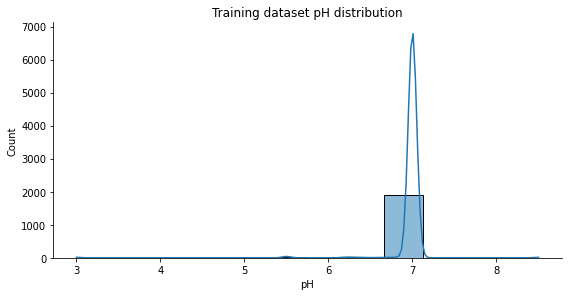

In [ ]:
# check distribution of the pH
sns.displot(train_df['pH'], aspect=2, height=4, kde=True).set(title="Training dataset pH distribution")

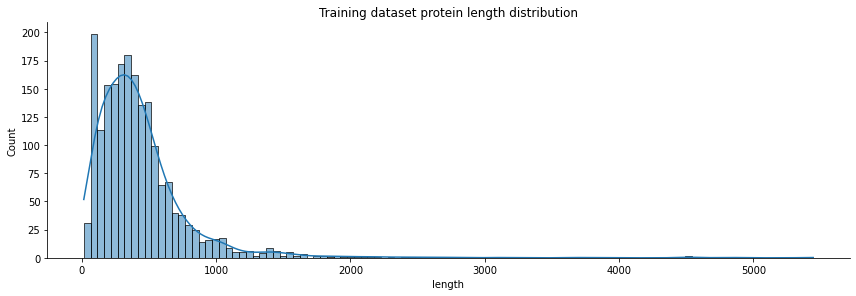

In [ ]:
# check distribution of the length of the sequence
sns.displot(train_df['length'], aspect=3, height=4, kde=True).set(title="Training dataset protein length distribution")

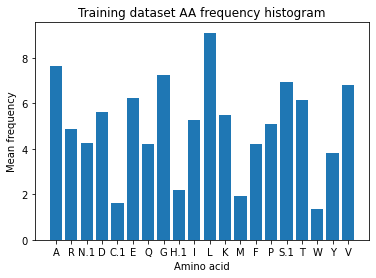

In [ ]:
# check the distribution of amino acid frequency

aa_freq = train_df.iloc[:,31:51].mean()
plt.bar(aa_freq.index, aa_freq.values)
plt.xlabel("Amino acid")
plt.ylabel("Mean frequency")
plt.title("Training dataset AA frequency histogram")
plt.show()

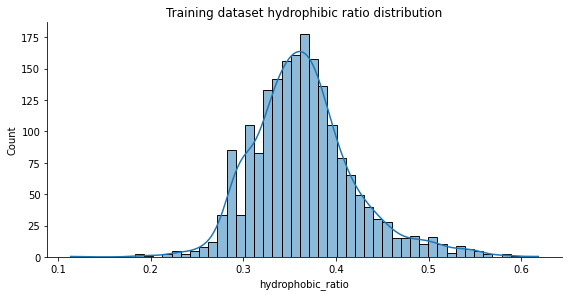

In [ ]:
# check distribution of the instability index
sns.displot(train_df['hydrophobic_ratio'], aspect=2, height=4, kde=True).set(title="Training dataset hydrophibic ratio distribution")

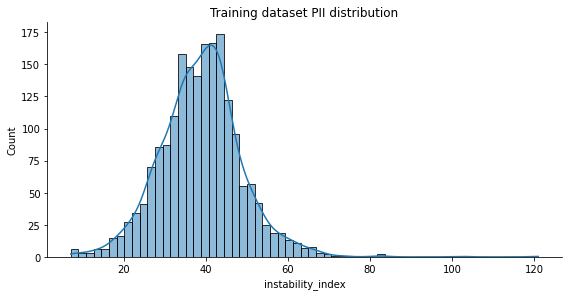

In [ ]:
# check distribution of the instability index
sns.displot(train_df['instability_index'], aspect=2, height=4, kde=True).set(title="Training dataset PII distribution")

Text(0, 0.5, 'Distributin of protein PII')

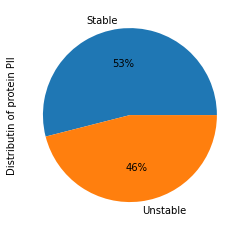

In [ ]:
# check PII estimation of stability and instability
copy_df = train_df.copy()

def pii_classification(x):
    if x < 40:
        return 'Stable'
    else:
      return 'Unstable'

copy_df['instability_index'] = train_df['instability_index'].apply(pii_classification)
copy_df.groupby('instability_index').size().plot.pie(autopct='%d%%')
plt.ylabel("Distributin of protein PII")

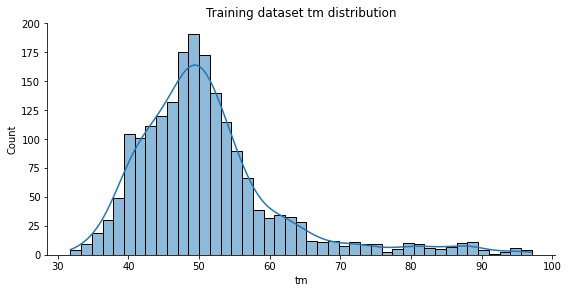

In [ ]:
# check distribution of the tm
sns.displot(train_df['tm'], aspect=2, height=4, kde=True).set(title="Training dataset tm distribution")

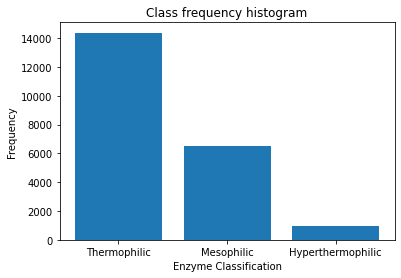

In [ ]:
# Classify the type of enzyme according to its thermostability
def thermostability_class(x):
    if x < 20:
        return 'Psychrophilic'
    elif 20 <= x <= 45:
        return 'Mesophilic'
    elif 45 <= x <= 80:
        return 'Thermophilic'
    elif x>= 80:
        return 'Hyperthermophilic'

copy_df['tm'] = train_df['tm'].apply(thermostability_class)
class_freq = copy_df['tm'].value_counts()

plt.bar(class_freq.index, class_freq.values)
plt.xlabel("Enzyme Classification")
plt.ylabel("Frequency")
plt.title("Class frequency histogram")
plt.show()

### Feature correlation

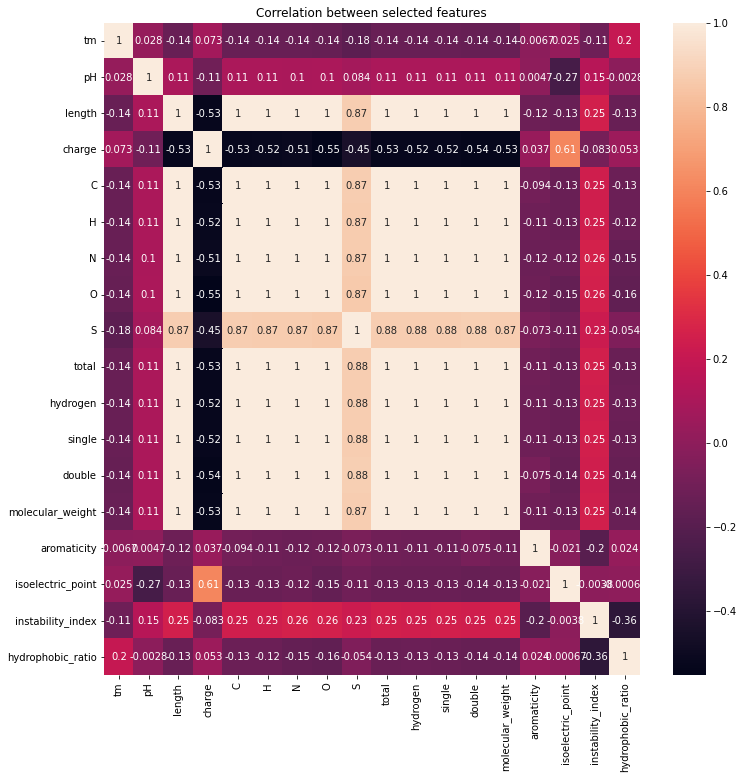

In [ ]:
# Check correlation value for selected features
corr = train_df.loc[:, ['tm', 'pH', 'length', 'charge', 'C', 'H', 'N', 'O', 'S', 'total', 'hydrogen', 'single', 'double', 'molecular_weight', 'aromaticity', 'isoelectric_point', 'instability_index', 'hydrophobic_ratio']].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True)
plt.title(f"Correlation between selected features")
plt.show()

### Data analysis and characterization

The initial information obtained from the training dataset allowed us to detect some anomalies, in fact the range of values of the pH and tm features had inaccuracies. The maximum value for pH was of ~ 64 and the minimum for temperature is usually 25 ºC. The optimal pH for most enzymes falls within the range of 6 to 8, although some enzymes may have an optimal pH outside this range, the maximum value is extremely alkaline. After checking the competition information, we saw that there had been updates to the training set and that some entries had transposed values for the pH and tm features. As such, we ran the suggested transformations to remove the data that was presumed unusable and alter the data that was corrected. The range of the features in this final dataset now fell within expected values.

The only filtering process applied to the dataset was verification of the protein sequences that was processed by the propythia package. The function par_preprocessing() removes and replaces incorrect amino acids. After verifying the sequences, we obtained all available descriptors in the propythia package using the get_all() method. This allowed us to have a final training dataset with 9601 features that will improve accuracy of the machine learning models.

In the following section we verified the data distribution of the most relevant features. As such, we plotted the distribution of the pH and the tm features, that were the original given ones, and the amino acid frequency, length of the protein sequences, the PII (Protein Instability Index) and hydrophobic ratio. To view how this features correlated with each other and with the tm we plotted a correlation plot.
Wu et al., (2009), states the protein properties that are most related to thermostability are amino acid composition, ion pairs and salt bridges.

For distribution of the pH, we can verify that the given values fall whithin the optimal range of enzyme activity, between 6 and 8, with most of the samples being in the 7.0 space. There are no expected ranges for the sequence length, however we can affirm that mean of the sequence length is of 440 amino acids with most of them falling between 0 and 2000. The protein instability index (PII) estimates the stability proteins in a test tube. If the PII is below 40 it can be predicted as stable and a value above 40 estimates some instability (Gasteiger et al., 2005). From the distribution plot and pie plot, we can affirm that almost half are stable.

Enzymes are classified according to their thermostability based on the optimal temperature at which they function. They can be psychrophilic, mesophilic, thermophilic and hyperthermophilic. The range of temperatures for each classification can vary depending on the source, but generally the following ranges are used: (1) Psychrophilic enzymes: active at low temperatures, typically between 0-20°C; (2) Mesophilic enzymes: active at moderate temperatures, typically between 20-45°C; (3) Thermophilic enzymes: active at high temperatures, typically between 45-80°C; (4) Hyperthermophilic enzymes:active at extremely high temperatures, typically above 80°C. We can see that none of the given enzymes are psychrophilic and that the majority are thermophilic.


## Unsupervised analysis

In this section of the notebook, we will be exploring various unsupervised analysis techniques to gain insights into the relationships among the features in our dataset. We will begin by analyzing the correlation among the features using a correlation feature plot. Next, we will use Principal Component Analysis (PCA) to reduce the dimensionality of the data and identify the most important features. Then, we will use variance thresholding to remove low-variance features from the dataset. Afterwards, we will use t-SNE to visualize the high-dimensional data in a two-dimensional space. Finally, we will use the K-Means clustering algorithm to group similar data points together and identify any underlying patterns in the data.

### Exploring data variance and PCA

In [ ]:
# Scale continuous data
input_data = train_df.iloc[:,3:].values
input_sc = preprocessing.scale(input_data)

In [ ]:
# calculate variance for each feature
variance_dict = train_df.iloc[:,3:].apply(lambda x: x.var()).to_dict()
variance_dict

In [ ]:
# Perform PCA
pca = PCA(n_components=20)
reduced_data = pca.fit(input_sc).transform(input_sc)
explained_variance = pca.explained_variance_ratio_
print('Explained variance: %s'% str(explained_variance))
print( f'Total variance: {explained_variance.sum()}.')

Explained variance: [0.02103672 0.01381732 0.01323078 0.00927726 0.00871384 0.007804
 0.00720149 0.00705156 0.00661096 0.00578184 0.00549506 0.00541096
 0.00512615 0.00499273 0.00476092 0.00464686 0.00429825 0.00401727
 0.00395868 0.00370018]
Total variance: 0.14693284307962887.


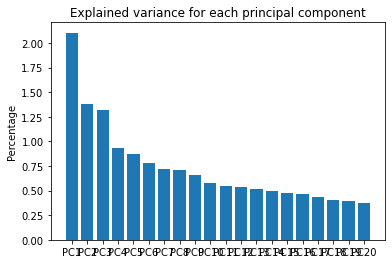

In [ ]:
# Plot explained variance
n = 20
plt.bar(range(n), explained_variance*100)
plt.xticks(range(n), ['PC'+str(i) for i in range(1,n+1)])
plt.title("Explained variance for each principal component")
plt.ylabel("Percentage")
plt.show()

In [ ]:
# Remove features with low variation

var_threshold = VarianceThreshold(threshold=0.1)
data_high_var = var_threshold.fit_transform(input_data)

print(data_high_var.shape)

(21880, 484)


In [ ]:
# Perform PCA after feature selection
data_high_var_scale = preprocessing.scale(data_high_var)

pca_var = PCA(n_components=10)
reduced_data_var = pca.fit(data_high_var_scale).transform(data_high_var_scale)
explained_variance_var = pca.explained_variance_ratio_
print('Explained variance: %s'% str(explained_variance_var))
print( f'Total variance: {explained_variance_var.sum()}.')

Explained variance: [0.22599071 0.03684078 0.03244573 0.02970085 0.02782635 0.02610302
 0.02351298 0.02032485 0.01786264 0.01634512 0.01501924 0.0142244
 0.01294063 0.01156259 0.01141457 0.01043116 0.01004311 0.00925337
 0.00870429 0.00836219]
Total variance: 0.5689085767230211.


### t-SNE

In [ ]:
# Perform t-SNE
# Extract the features and the target variable
data = train_df.drop(["tm"], axis=1).iloc[:,3:].values
data_scale = preprocessing.scale(data)
target = train_df["tm"].values
target_scale = preprocessing.scale(target)

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(data_scale)

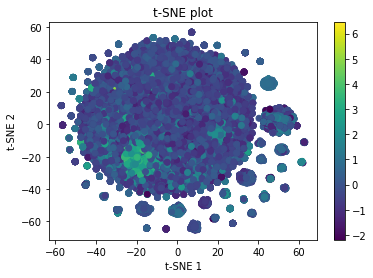

In [ ]:
# Map t-SNE data point in a 2D plot
cmap = cm.ScalarMappable(cmap='viridis')
cmap.set_array(target_scale)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=target_scale, cmap='viridis')
plt.colorbar(cmap)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE plot')
plt.show()

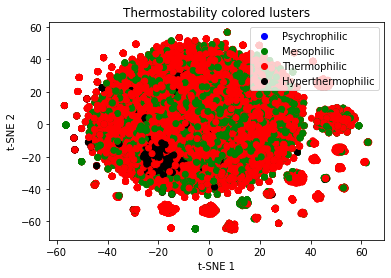

In [ ]:
# Cluster according to thermostability classification

class_tm_colors = {'Psychrophilic':'blue', 'Mesophilic':'green', 'Thermophilic':'red','Hyperthermophilic':'black'}
class_colors = []

for classification in copy_df['tm']:
    class_colors.append(class_tm_colors[classification])

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=class_colors)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Thermostability colored lusters')
handles = [plt.plot([], marker="o", ls="", color=class_tm_colors[c], label=c)[0] for c in class_tm_colors]
plt.legend(handles=handles)
plt.show()

### K-Means Clustering

In [ ]:
# Methods to discover optimal number of clusters - Silhouette method
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsne_result)
    labels = kmeans.labels_
    silhouette = silhouette_score(tsne_result, labels)
    print("Number of clusters: ", k, " - Silhouette score: ", silhouette)

Number of clusters:  2  - Silhouette score:  0.3305701
Number of clusters:  3  - Silhouette score:  0.3652981
Number of clusters:  4  - Silhouette score:  0.3557958
Number of clusters:  5  - Silhouette score:  0.35212088
Number of clusters:  6  - Silhouette score:  0.36621302
Number of clusters:  7  - Silhouette score:  0.3623076
Number of clusters:  8  - Silhouette score:  0.34599093
Number of clusters:  9  - Silhouette score:  0.35721534
Number of clusters:  10  - Silhouette score:  0.34491292


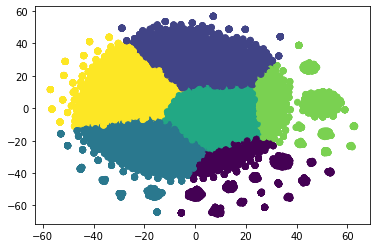

In [ ]:
# Kmean with optimal cluster number
n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(tsne_result)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters)
plt.show()

## Critical analysis of the results

After selecting a few relevant features we can verify that the data has low linearity. To further verify the structure of the data we performed PCA to reduce the dimensionality of the data. Several numbers of componentes were tried (5, 10, 20, 50), however these values only explained about 15% of the total variance. As the normal percentage of explained variance is around 70-80%, we removed features with a low variance. Even after feature selection, only 57% of the total variance was explained.
We then tried a t-SNE technique, more appropriate for non-linear data. From the t-SNE technique it was difficult to identify defined clusters. We also plotted the t-SNE data points accordind to the thermostability classification to verify if there was any relationship, however no pattern was found.
For the Kmeans clustering, as the group was unsure on the number of clusters to choose from, we decided to compute the Silhouette score to arrive at the best solution. The Silhouette score measures how similar an object is to its own cluster compared to other clusters. This methods allowed us to infer that the best number of clusters was 6. After resorting to the KMeans technique we can easily observe 6 defined groups with a few outliers in the periferia.

## Machine Learning Pipeline

In this notebook section, we will be performing a machine learning analysis using various regression models such as Support Vector Regressor, Random Forest Regressor, KNN Regressor, and XGBoost Regressor. We will also be applying feature selection techniques like Recursive Feature Elimination (RFE) and hyperparameter tuning with Random Search Cross-Validation (CV). The performance of each model will be evaluated using the Mean Squared Error (MSE) as the scoring metric, and the results will be compared using cross-validation. The objective of this analysis is to identify the best performing model and feature set for our dataset. This section is organized by three big subsections where 1) the input/output data is pre-processed; 2) the chosen ML models are trained with no optimization techniques and 3) the models are trained with reduced features and then hyperparameter optimization. The group would also like to make a disclaimer that due to deprecation warnings and extended outputs some of these were cleared and the relevant information was inserted in a Markdown cell to keep the notebook clean.

In [ ]:
# imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats

### Prepare the datasets

In [ ]:
# Prepare the data for the devision of the datasets
x = train_df.drop(["tm"], axis=1).iloc[:,3:].values
x = preprocessing.scale(x)
y = train_df["tm"].values
y = preprocessing.scale(y)

In [ ]:
# Divide the datasets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

print(f"The shape of the input and output training data is {x_train.shape} and {y_train.shape}, respectively.")
print(f"The shape of the input and output testing data is {x_test.shape} and {y_test.shape}, respectively.")
print(f"The shape of the input and output validating data is {x_val.shape} and {y_val.shape}, respectively.")

The shape of the input and output training data is (7070, 9597) and (7070,), respectively.
The shape of the input and output testing data is (884, 9597) and (884,), respectively.
The shape of the input and output validating data is (884, 9597) and (884,), respectively.


In [ ]:
# Prepare the datasets
# Train
train_dataset = pd.read_csv("train_dataset.csv")
train_columns = train_dataset.columns
train_label = train_columns[-1]

x_train = train_dataset.drop(train_label, axis=1)
y_train = train_dataset[train_label]

#Test
test_dataset = pd.read_csv("test_dataset.csv")
test_columns = test_dataset.columns
test_label = test_columns[-1]

x_test = test_dataset.drop(test_label, axis=1)
y_test = test_dataset[test_label]

#Validation
val_dataset = pd.read_csv("val_dataset.csv")
val_columns = val_dataset.columns
val_label = val_columns[-1]

x_val = val_dataset.drop(val_label, axis=1)
y_val = val_dataset[val_label]

In [ ]:
# Fill training set Nan values (temporary due to running time on the loading of the dataset)
medians = train_dataset.median()
train_dataset = train_dataset.fillna(medians)

train_columns = train_dataset.columns
train_label = train_columns[-1]

x_train = train_dataset.drop(train_label, axis=1)
y_train = train_dataset[train_label]

### Baseline models

In order to have a baseline for the comparison of the performance for the implemented models, the chosen ML algorithms were trained using the complete training dataset, meaning that no feature selection technique was performed.

#### Linear Regression

In [ ]:
# Create the linear regression model
lr = LinearRegression()

lr.fit(x_train, y_train)

lr_scores = cross_val_score(lr, x_train, y_train, cv=5)
print("Original Model Scores (CV on train set):", lr_scores)

Original Model Scores (CV on train set): [-4.58713859e+24 -1.02616170e+25 -1.39419224e+25 -1.16370157e+24
 -3.72414770e+24]


### Support Vector Machine (SVM)

In [ ]:
# Create the SVR model

svr = SVR()
svr.fit(x_train, y_train)

scores = cross_val_score(svr, x_train, y_train, cv=5)
print("Original Model Scores (CV on train set):", scores)

Original Model Scores (CV on train set): [0.30433215 0.30804683 0.30717494 0.33512187 0.31897342]


#### Random Forests (RF)

In [ ]:
# Create the RFR model
rfr = RandomForestRegressor()

rfr.fit(x_train, y_train)

rfr_scores = cross_val_score(rfr, x_train, y_train, cv=5)
print("Original Model Scores (CV on train set):", rfr_scores)

Original Model Scores (CV on train set): [0.45497179 0.40872392 0.4707737  0.42808391 0.38926285]


#### K-nearest neighbor (KNN)

In [ ]:
# Create the KNN model

knn = KNeighborsRegressor()
knn.fit(x_train, y_train)

knn_scores = cross_val_score(knn, x_train, y_train, cv=5)
print("Original Model Scores (CV on train set):", knn_scores)

Original Model Scores (CV on train set): [0.28738462 0.19080767 0.19040257 0.11388853 0.2486787 ]


#### Extreme Gradient Boosting (XGBoost)

In [ ]:
# Create the XGBoost model

xgb = XGBRegressor()
xgb.fit(x_train, y_train)

xgb_scores = cross_val_score(xgb, x_train, y_train, cv=5)
print("Original Model Scores (CV on train set):", xgb_scores)

Original Model Scores (CV on train set): [0.47549222  0.48652976  0.41872815  0.50310552]

### Model optimization

After training the ML models on the complete dataset, the group decided to employ optimization techniques to improve the models' performance. Due to prolongued running times, the selection of the best performing features was applied to the best scoring model, Extreme Gradient Boosting Regressor. For this step, we resorted to SelectKBest and GridSearchCV to identify the most informative features for training the model. This is achieved by iteratively removing the least important features, and using cross-validation to evaluate different combinations of the number of features selected. The final result is the selection of the optimal number of features that results in the best performance of the model. After obtaining this information, the original datasets were transformed, containing the reduced features and these datasets were applied to the remaining ML model. Note that due to the performance evaluation of the Linear Regression model, this algorithm was disgregarded.

#### Feature Selection

In [ ]:
# Grid Search method to infer the best number and scoring feature
xgb_skb_pipe = Pipeline([
    ('skb', SelectKBest(score_func=f_regression)),
    ('xgb', XGBRegressor())
])

xgb_skb_param_grid = {'skb__k': range(1, 9500, 500)}

xgb_skb_grid_search = GridSearchCV(xgb_skb_pipe, xgb_skb_param_grid, cv=5)
xgb_skb_grid_search.fit(x_train, y_train)

print("Best number of features: ", xgb_skb_grid_search.best_params_)

Best number of features:   {'skb__k': 7501}

In [ ]:
# Transform the dataset with the best perfoming features
xgb_red_features = xgb_skb_grid_search.best_estimator_
skb = xgb_red_features.named_steps['skb']
indices = skb.get_support(indices=True)
x_train_red = x_train.iloc[:,indices]
x_test_red = x_test.iloc[:,indices]
x_val_red = x_val.iloc[:,indices]
y_train_red = y_train[x_train_red.index]
y_test_red = y_test[x_test_red.index]
y_val_red = y_val[x_val_red.index]

In [ ]:
#Save indices
np.savetxt('indices_red.txt', indices, delimiter=',')

In [ ]:
print(f"The shape of the transformed training data and label is {x_train_red.shape} and {y_train_red.shape}, respectively.")
print(f"The shape of the transformed training data and label is {x_test_red.shape} and {y_test_red.shape}, respectively.")
print(f"The shape of the transformed training data and label is {x_val_red.shape} and {y_val_red.shape}, respectively.")

The shape of the transformed training data and label is (1631, 7501) and (1631,), respectively.
The shape of the transformed training data and label is (884, 7501) and (884,), respectively.
The shape of the transformed training data and label is (884, 7501) and (884,), respectively.


In [ ]:
# Save reduced datasets to a CSV file

x_train_red_df = pd.DataFrame(x_train_red)
x_train_red_df.to_csv("x_train_red.csv", index=False)

x_test_red_df = pd.DataFrame(x_test_red)
x_test_red_df.to_csv("x_test_red.csv", index=False)

x_val_red_df = pd.DataFrame(x_val_red)
x_val_red_df.to_csv("x_val_red.csv", index=False)

y_train_red_df = pd.DataFrame(y_train_red)
y_train_red_df.to_csv("y_train_red.csv", index=False)

y_test_red_df = pd.DataFrame(y_test_red)
y_test_red_df.to_csv("y_test_red.csv", index=False)

y_val_red_df = pd.DataFrame(y_val_red)
y_val_red_df.to_csv("y_val_red.csv", index=False)

In [ ]:
# Read reduced datasets
x_test_red = pd.read_csv("x_test_red.csv")
x_train_red = pd.read_csv("x_train_red.csv")
x_val_red = pd.read_csv("x_val_red.csv")
y_train_red = pd.read_csv("y_train_red.csv")
y_test_red = pd.read_csv("y_test_red.csv")
y_val_red = pd.read_csv("y_val_red.csv")

#### XGB-Regressor

In [ ]:
# Score the model on reduced features
xgb_rfesc = XGBRegressor()
xgb_rfesc.fit(x_train_red, y_train_red)

xgb_rfe_val_score = xgb_rfesc.score(x_val_red, y_val_red)
print("Validation score: ", xgb_rfe_val_score)

[21:37:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation score:  0.43905261675984564


In [ ]:
# Define the hyperparameter grid
xgb = XGBRegressor()

xgb_param_grid = {"n_estimators": stats.randint(150, 1000),
                   "learning_rate": stats.uniform(0.01, 0.59),
                   "subsample": stats.uniform(0.3, 0.6),
                   "max_depth": [3, 4, 5, 6, 7, 8, 9],
                   "colsample_bytree": stats.uniform(0.5, 0.4),
                   "min_child_weight": [1, 2, 3, 4]
                   }
xgb_random_search = RandomizedSearchCV(xgb, xgb_param_grid, n_iter=10, cv=None)

xgb_random_search.fit(x_train_red, y_train_red)

print("Best Hyperparameters:", xgb_random_search.best_params_)
xgb_scores = xgb_random_search.best_estimator_.score(x_val_red, y_val_red)
print("Final Model Scores (validation set): ", xgb_scores)
print("Final Model Scores (test set): ", xgb_random_search.best_estimator_.score(x_test_red, y_test_red))

Best Hyperparameters: {'colsample_bytree': 0.7165445227982199, 'learning_rate': 0.046225764767013754, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 648, 'subsample': 0.8925036464315721}
Final Model Scores (validation set):  0.4189417970205491
Final Model Scores (test set):  0.4031703499005228

#### KNN-Regressor

In [ ]:
# Score the model on reduced features
knn_rfesc = KNeighborsRegressor()
knn_rfesc.fit(x_train_red, y_train_red)

knn_rfe_val_score = knn_rfesc.score(x_val_red, y_val_red)
print("Validation score: ", knn_rfe_val_score)

Validation score:  0.25014839849132475


In [ ]:
# Hyperparameter tunning
knn = KNeighborsRegressor()

knn_param_grid = {'n_neighbors': [3, 5, 7], 
              'weights': ['uniform', 'distance'],
              'p': [1, 2, 3]}
knn_random_search = RandomizedSearchCV(knn, knn_param_grid, n_iter=10, cv=None)
knn_random_search.fit(x_train_red, y_train_red)


print("Best Hyperparameters:", knn_random_search.best_params_)
knn_scores = knn_random_search.best_estimator_.score(x_val_red, y_val_red)
print("Randomized Search Model Scores (CV on validation set):", knn_scores)
print("Final Model Scores (test set): ", knn_random_search.best_estimator_.score(x_test_red, y_test_red))

Best Hyperparameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 5}
Randomized Search Model Scores (CV on validation set): 0.253733197611256
Final Model Scores (test set):  0.21525191803590138


### SVR

In [ ]:
# Score the model on reduced features
svr_rfesc = SVR()
svr_rfesc.fit(x_train_red, y_train_red)

svr_rfe_val_score = svr_rfesc.score(x_val_red, y_val_red)
print("Validation score: ", svr_rfe_val_score)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation score:  0.34113289244493483


In [ ]:
# Hyperparameter tuning
svr = SVR()

svr_param_grid = {'C': np.logspace(-3, 3, 7), 
              'kernel': ['linear', 'rbf'], 
              'gamma': np.logspace(-3, 3, 7)}

svr_random_search = RandomizedSearchCV(svr, svr_param_grid, n_iter=10, cv=None)

svr_random_search.fit(x_train_red, y_train_red)


print("Best Hyperparameters:", svr_random_search.best_params_)
svr_scores = svr_random_search.best_estimator_.score(x_val_red, y_val_red)
print("Randomized Search Model Scores (CV on validation set):", svr_scores)
print("Final Model Scores (test set): ", svr_random_search.best_estimator_.score(x_test_red, y_test_red))

Best Hyperparameters: {'kernel': 'linear', 'gamma': 1000.0, 'C': 0.1}
Randomized Search Model Scores (CV on validation set): -0.04970651341886567
Final Model Scores (test set):  -0.047410874681277804


### RFR

In [ ]:
# Score the model on reduced features
rfr_rfesc = RandomForestRegressor()
rfr_rfesc.fit(x_train_red, y_train)

rfr_rfe_val_score = rfr_rfesc.score(x_val_red, y_val_red)
print("Validation score: ", rfr_rfe_val_score)

<ipython-input-12-8f38b1078338>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr_rfesc.fit(x_train_red, y_train)


Validation score:  0.4349473606140928


In [ ]:
# Hyperparameter tuning
rfr = RandomForestRegressor()
rf_param_grid = {"bootstrap": [True, False],
                  "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                  "max_features": ['sqrt'],
                  "min_samples_leaf": [1, 2, 4],
                  "min_samples_split": [2, 5, 10],
                  "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_random_search = RandomizedSearchCV(rfr, rf_param_grid, n_iter=10, cv=None)
rf_random_search.fit(x_train_red, y_train_red)

print("Best Hyperparameters:", rf_random_search.best_params_)
rf_scores = rf_random_search.best_estimator_.score(x_val_red, y_val_red)
print("Randomized Search Model Scores (CV on validation set):", rf_scores)
print("Final Model Scores (test set): ", rf_random_search.best_estimator_.score(x_test_red, y_test_red))

Best Hyperparameters: {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Randomized Search Model Scores (CV on validation set): 0.3664774782984801
Final Model Scores (test set):  0.3612198991727821


## Critical analysis of the ML models

The input data was selected, removing the categorical data (protein sequence) and the target feature. The output data was added as a new variable and all the data was scaled, ensuring that all features of the dataset are on the same scale and have similar properties. This is important because many machine learning algorithms use the scale of the input features to weight their importance. After this step, the data was divided in a training, testing and validation set, to improve results in the finetuning of the model. As the initial dataset with all the descriptors is heavy, the group decided to save the data divisions to avoid reading the dataset at every run. This also aids in the reproducibility and comparision of the ML results.

In order to have a baseline for the comparision of the models, they were trained with the complete training set, meaning that no feature selection techniques were applied. For this step, the best obtained score was of 0.503 for the XGBoost Regressor. As such, due to the prolonged running times we executed SelectKBest in this model with GridSearchCV to verify the best number of features to train the model.

When compared to the mean score of the baseline models, all the models trained with reduced features had similar scores: XGB (Mean for the baseline: 0.439; Feature selection: 0.466); SVR (0,315; 0.341); RFM (0.430; 0.435); KNN (0.201 ;0.250). The score similarity between the models trained with all features and feature selection means that the feature selection is not affecting the model performance negatively. As such, the selected features are representative of the underlying data structure, and the model is able to generalize well to new data. This can also be a sign that the model is not overfitting.

After optimization of the hyperparametrs, the scores of the models also didn't present significant additional improvement. In fact, most models' score lowered (XGB (Feature selection: 0.466; Hyperparameter tunning: 0.403); RF (0.435; 0.361); KNN (0.250; 0.215); SVR (0.3413;-0.047)). With small changes in the score of the XGB and KNN and more drastic changes with the RF and the SVR model, the last one significantly decreased. This means that models' performance decreased with the addition of hyperparameters. This can be due to several reasons, such as overfitting, choosing inappropriate hyperparameters or that the model is is not generalizing well to new data.

For this analysis, the group infered that the best performing models is the XGBoost-Regressor model, when trained with the complete dataset.



## Deep-Learning Analysis

In this section, we perform deep learning analysis using Long Short-Term Memory (LSTM) and Convolutional 1D (CNN1D) networks. We optimize the hyperparameters of these models using GridSearchCV and EarlyStop to obtain the best results. Before conducting the analysis with the CNN1D model, we reshape the data to fit the required input format. This section is organized by models, with each having a separte subsection where we first train a baseline model with the standard hyperparameter and then procede to hyperparameter optimization. The group would also like to make a disclaimer that due to deprecation warnings and extended outputs some of these were cleared and the relevant information was inserted in a Markdown cell to keep the notebook clean.

In [ ]:
# imports
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.metrics import r2_score
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping

### LSTM Model

#### Baseline

In [ ]:
# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(x_train.shape[1], 1)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# Evaluate the model
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("R-squared score on test data: ", r2)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
201/201 [==============================] - 657s 3s/step - loss: 0.9854 - val_loss: 0.9363
Epoch 2/10
201/201 [==============================] - 640s 3s/step - loss: 0.9687 - val_loss: 0.9071
Epoch 3/10
201/201 [==============================] - 659s 3s/step - loss: 0.9510 - val_loss: 0.9406
Epoch 4/10
201/201 [==============================] - 647s 3s/step - loss: 0.9355 - val_loss: 0.8971
Epoch 5/10
201/201 [==============================] - 650s 3s/step - loss: 0.9214 - val_loss: 0.8585
Epoch 6/10
201/201 [==============================] - 649s 3s/step - loss: 0.9139 - val_loss: 0.8642
Epoch 7/10
201/201 [==============================] - 649s 3s/step - loss: 0.9017 - val_loss: 0.8454
Epoch 8/10
201/201 [==============================] - 652s 3s/step - loss: 0.8957 - val_loss: 0.8388
Epoch 9/10
201/201 [==============================] - 648s 3s/step - loss: 0.8872 - val_loss: 0.8391
Epoch 10/10
28/28 [==============================] - 24s 846ms/step
R-squared score on test

#### Hyperparameter optimization

In [ ]:
# Hyperparameter optimization
def create_LSTMmodel(units=30, lr=0.001):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(x_train.shape[1], 1)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
    return model

param_grid = {'units': [30, 60, 100]}

model = KerasRegressor(build_fn=create_LSTMmodel)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=None, verbose=0)
grid_search.fit(x_train, y_train, epochs=5, batch_size=256, validation_data=(x_val, y_val), verbose=0)

# Print the best hyperparameters and the final scores on the validation and test sets
print("Best Hyperparameters:", grid_search.best_params_)
print("Final Model Scores (validation set): ", grid_search.score(x_val, y_val))
print("Final Model Scores (test set): ", grid_search.score(x_test, y_test))

Best Hyperparameters: {'units': 60}
Final Model Scores (validation set):  0.014115848518208907
Final Model Scores (test set):  0.013321952578419505

### CNN Model

In [ ]:
#Reshape data
x_train = x_train.values
x_val = x_val.values
x_test = x_test.values
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#### Baseline model

In [ ]:
# Define 1D Convolutional model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

# Reshape data to 3D for 1D Convolution
x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# Evaluate the model
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("R-squared score on test data: ", r2)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
115/115 [==============================] - 19s 156ms/step - loss: 5.7337 - val_loss: 1.5357
Epoch 2/10
115/115 [==============================] - 18s 155ms/step - loss: 2.0982 - val_loss: 1.0482
Epoch 3/10
115/115 [==============================] - 18s 154ms/step - loss: 2.6053 - val_loss: 1.4443
Epoch 4/10
115/115 [==============================] - 18s 154ms/step - loss: 1.1579 - val_loss: 0.7494
Epoch 5/10
115/115 [==============================] - 18s 153ms/step - loss: 0.3596 - val_loss: 0.6733
Epoch 6/10
115/115 [==============================] - 18s 154ms/step - loss: 0.3070 - val_loss: 0.7087
Epoch 7/10
115/115 [==============================] - 18s 153ms/step - loss: 0.3153 - val_loss: 0.7587
Epoch 8/10
115/115 [==============================] - 18s 154ms/step - loss: 0.3394 - val_loss: 0.7706
Epoch 9/10
115/115 [==============================] - 18s 153ms/step - loss: 0.3645 - val_loss: 0.7550
Epoch 10/10
28/28 [==============================] - 1s 46ms/step
R-squar

#### Hyperparameter optimization

In [ ]:
# Hyperparameter optimization
def create_Conv1Dmodel(filters=32, kernel_size=3, lr=0.001):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error',  optimizer=Adam(learning_rate=lr))
    return model

param_grid = {'filters': [32, 64],
              'kernel_size': [2, 4]}

model = KerasRegressor(build_fn=create_Conv1Dmodel)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=None, verbose=0)
grid_search.fit(x_train, y_train, epochs=5, batch_size=256)

# Print the best hyperparameters and the final scores on the validation and test sets
print("Best Hyperparameters:", grid_search.best_params_)
print("Final Model Scores (validation set): ", grid_search.score(x_val, y_val))
print("Final Model Scores (test set): ", grid_search.score(x_test, y_test))

Best Hyperparameters: {'filters': 32, 'kernel_size': 2}
Final Model Scores (validation set):  -0.768415778974155
Final Model Scores (test set):  -0.6947783487960033

### Critical analysis of the results

For the DL analysis, the group was already expecting the scores of the models to be suboptimal. The reasoning behind this is that DL algorithms are more complex than traditional ML models due to the use of multiple non-linear transformations and complex network architectures. As a result, DL models require more data to learn complex patterns and generalize these relationships to new, unseen data to make accurate predictions. For the baseline models, the CNN model (0.202) scored better that the LSTM model (0.108); while for the model subjected to hyperparameter optimization, the scores were dramatically lower (0.013 for the LSTM model and -0.700 for the CNN model). For the hyperparameter grid in both models, the initially defined grid was more extensive, with a higher number of combinations of parameters. The initial number of epochs was 100 with an implemented EarlyStopping of patience 15. However, the running time of these models was extensive. As such, the parameter grid for these models and the epochs were reduced and the EarlyPatience was removed. Although several values were defined in the parameter grid, later batch size was defined to a sole value of 32 and then changed to 256 to accelerate running time. 

In an analysis with more time, more parameters could have been added to further evaluate the model performance and optimize the obtained scores.